In [478]:
import gpflow as gpf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(100)
from IPython.display import clear_output

In [881]:
# Initialise 20 sensor locations (x1,x2) 
X1 = 2*np.random.rand(20) - 1
X2 = 2*np.random.rand(20) - 1

# time linearly spaced, one obs per hour for 30 days
t = np.linspace(0,30*24,30*24)

In [882]:
# True f function
def true_f(data):
    X1, X2, t = data
    return 3*(np.sin(0.05*t) + np.cos(0.3*X1) + np.sin(0.02*X2))

In [884]:
# create X data, N x 3
X = []
for i in range(len(X1)):
    for tstep in t:
        X.append([X1[i], X2[i],tstep])
X = np.array(X)
X.shape

(14400, 3)

In [896]:
# latent function, N x 1
Y =  np.array([[true_f(obs) + 0.8*np.random.randn()] for obs in X])

In [897]:
len(Y)

14400

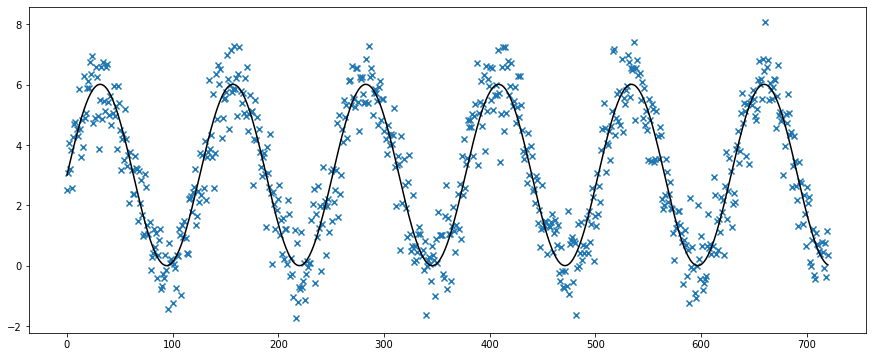

In [916]:
# plot time data for first sensor
sens = 1
plt.figure(figsize=(15,6))
plt.scatter(t,Y[(sens-1)*len(t):sens*len(t)], marker="x")
plt.plot(t,[true_f(obs) for obs in X[(sens-1)*len(t):sens*len(t)]], color="k")

In [917]:
# initialise SVGP model

kernel = gpf.kernels.SquaredExponential(variance = 1.0, lengthscales = 0.1*np.ones(X.shape[1])) 
model = gpflow.models.SVGP(kernel = kernel,
                            likelihood = gpflow.likelihoods.Gaussian(), 
                            inducing_variable = X[::1000])
gpflow.set_trainable(model.inducing_variable, False)
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.1 0.1 0.1]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(15, 3)",float64,"[[-1.18336907e-01, 1.87170486e-01, 0.00000000e+00..."
SVGP.q_mu,Parameter,,,True,"(15, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 15, 15)",float64,"[[[1., 0., 0...."


In [918]:
# test data set, using one sensor and 100 linspaced timepoints
Xt = np.linspace(0, max(t), 100)
_ = np.c_[np.full(Xt.shape, X1[0]), np.full(Xt.shape, X2[0])]
Xtest = np.c_[_, Xt]
Xtest[:10]

array([[-0.11833691,  0.18717049,  0.        ],
       [-0.11833691,  0.18717049,  7.27272727],
       [-0.11833691,  0.18717049, 14.54545455],
       [-0.11833691,  0.18717049, 21.81818182],
       [-0.11833691,  0.18717049, 29.09090909],
       [-0.11833691,  0.18717049, 36.36363636],
       [-0.11833691,  0.18717049, 43.63636364],
       [-0.11833691,  0.18717049, 50.90909091],
       [-0.11833691,  0.18717049, 58.18181818],
       [-0.11833691,  0.18717049, 65.45454545]])

Text(0.5, 1.0, 'Predictions before training')

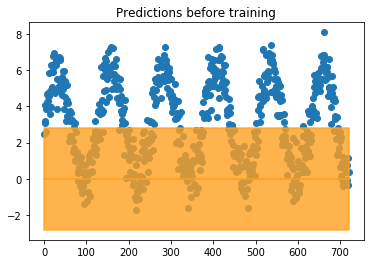

In [919]:
# plot data
plt.scatter(t,Y[:len(t)])
Yt, Yv = model.predict_y(Xtest)
_ = plt.plot(Xt, Yt, c="#ffa01f")
plt.fill_between(
        Xt,
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
    )
plt.title("Predictions before training")

In [929]:
def run_adam(model, iterations, data):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    :param data: observed data set
    :return logf: model training loss
    """
    # Create an Adam Optimizer action
    logf = []
    step = []
    training_loss = model.training_loss_closure(data)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    # Optimize variational parameters 
    for iter in range(iterations):
        optimization_step()
        if iter % 10 == 0:
            loss = -training_loss().numpy()
            logf.append(loss)
            step.append(iter)
            clear_output(wait=True)
            print("iteration {}".format(iter))
    return step, logf

In [930]:

data = (X,Y)
data[:][:10]

(array([[-1.18336907e-01,  1.87170486e-01,  0.00000000e+00],
        [-1.18336907e-01,  1.87170486e-01,  1.00139082e+00],
        [-1.18336907e-01,  1.87170486e-01,  2.00278164e+00],
        ...,
        [ 1.27153122e-01,  5.26117619e-01,  7.17997218e+02],
        [ 1.27153122e-01,  5.26117619e-01,  7.18998609e+02],
        [ 1.27153122e-01,  5.26117619e-01,  7.20000000e+02]]),
 array([[ 2.49728237],
        [ 3.07634375],
        [ 4.07427794],
        ...,
        [-0.32969211],
        [ 0.21566626],
        [ 0.11838094]]))

In [931]:
step, logf = run_adam(model, 15000, data)

iteration 14990


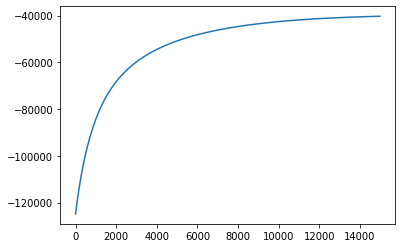

In [932]:
plt.plot(step,logf)

Text(0.5, 1.0, 'Predictions after training')

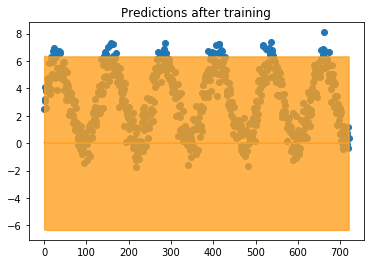

In [934]:
plt.scatter(t,Y[:len(t)])
Yt, Yv = model.predict_y(Xtest)
_ = plt.plot(Xt, Yt, c="#ffa01f")
plt.fill_between(
        Xt,
        (Yt - 2 * Yv ** 0.5)[:, 0],
        (Yt + 2 * Yv ** 0.5)[:, 0],        
        alpha=0.8,
        lw=1.5,
        color = "#ffa01f"
    )
plt.title("Predictions after training")

In [935]:
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.007208093075674873
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[4.80034213 4.87538126 0.09397297]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,10.004004539723915
SVGP.inducing_variable.Z,Parameter,,,False,"(15, 3)",float64,"[[-1.18336907e-01, 1.87170486e-01, 0.00000000e+00..."
SVGP.q_mu,Parameter,,,True,"(15, 1)",float64,[[0.53173263...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 15, 15)",float64,"[[[0.99305795, 0., 0...."
